In [1]:
import os
import pandas as pd
import utils as utils

DATA_PATH = '../../backend/data/database/'

In [2]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(76, 8)

In [3]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
47,64ff77269d93d4c79f8a58c5,machine,2.0,L341,R915,L122,R751,finished
2,5c131126d6d169000148414a,placebo,3.0,L159,L482,R314,R723,finished
41,62babccea6f10f16ce6a5a75,human,1.0,R552,R669,L614,L654,finished
74,671fcf0fcd980b58b009f7dc,placebo,2.0,L576,L219,R310,R365,finished
72,66e37f6a5a5359eb88ccd478,human,6.0,R264,R060,L057,L995,finished
63,667d9e3136e04a629c3f290d,human,3.0,R009,L719,R250,L145,finished
42,6346e2da58119734e201d767,human,8.0,L044,R126,L946,R388,finished
57,6658b69e777a6d0ee2bbeb26,machine,2.0,L910,R366,R451,L294,finished
31,61215755cea9b916eef0a38b,machine,2.0,L048,R328,R036,L472,finished
29,60feeca75b7f7bd139510c61,machine,2.0,L285,R346,R276,L914,finished


In [4]:
# selecting participants that finished the survey
qualif_participants = participants_df.loc[participants_df['ParticipantStatus']=='finished'].reset_index(drop=True)
qualif_participants.shape

(73, 8)

In [5]:
qualif_participants['PoliticalLeaning'] = qualif_participants['PoliticalLeaning'].map(lambda x: utils.proc_participant_leaning(x))
qualif_participants['PoliticalLeaning'].value_counts()

PoliticalLeaning
center-left     24
left            18
center-right    10
center           8
not informed     5
right            5
far-left         2
far-right        1
Name: count, dtype: int64

<Axes: xlabel='PoliticalLeaning'>

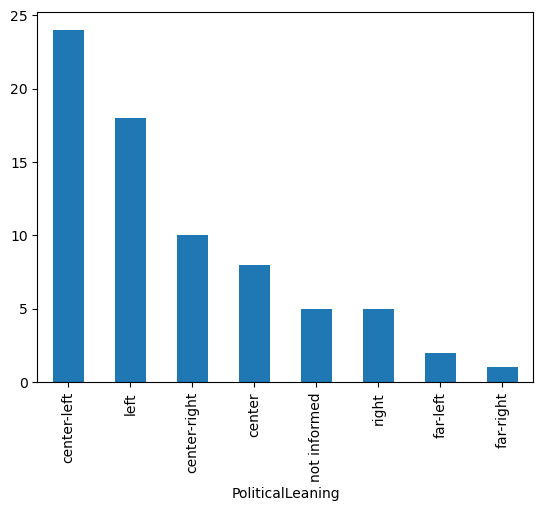

In [6]:
qualif_participants['PoliticalLeaning'].value_counts().plot.bar()

In [7]:
qualif_participants['TreatmentGroup'].value_counts()

TreatmentGroup
machine    25
placebo    24
human      24
Name: count, dtype: int64

In [8]:
answers_df = pd.read_parquet(os.path.join(DATA_PATH, 'answers.parquet'))
answers_df.dropna(axis=0, how='any', inplace=True)
answers_df.shape

(292, 10)

In [9]:
# selecting answer from qualified participants
qualif_answers = answers_df.loc[answers_df['FK_ParticipantId'].isin(qualif_participants['ParticipantId'].values)].reset_index(drop=True)
qualif_answers.shape

(292, 10)

In [10]:
qualif_answers.head(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
0,57bb0ebfd4654c00018e0261T1,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR749,R749,4.0,5.0,5.0,2.0,44
1,57bb0ebfd4654c00018e0261T2,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,L167,ML167,3.0,3.0,5.0,3.0,43
2,57bb0ebfd4654c00018e0261T3,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR050,R050,2.0,5.0,4.0,2.0,58
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64
4,5ab848ffe1546900019b6ec9T1,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L211,ML211,5.0,2.0,4.0,1.0,59
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55
6,5ab848ffe1546900019b6ec9T3,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,MR942,R942,4.0,5.0,2.0,2.0,66
7,5ab848ffe1546900019b6ec9T4,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,R528,MR528,4.0,2.0,4.0,1.0,40
8,5c131126d6d169000148414aT1,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,PL159,L159,4.0,4.0,5.0,1.0,59
9,5c131126d6d169000148414aT2,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,L482,PL482,4.0,4.0,4.0,3.0,21


In [11]:
new_values = []

for idx, row in qualif_answers.iterrows():
    treated_polar, treated_likert, original_polar, original_likert = utils.get_polar_info(row)
    treated_less_polar = utils.is_treated_less_polar(row)
    diff_likert_treated_original = utils.get_treat_diff(row)
    tweet_bias = utils.proc_tweet_bias(utils.get_tt_bias(row['Text1']))
    participant_leaning = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['PoliticalLeaning'].values[0]
    treatment_group = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['TreatmentGroup'].values[0]
    new_values.append(
        {
            'TreatedIsPolarized' : treated_polar,
            'OriginalIsPolarized' : original_polar,
            'TreatedIsLessPolar' : treated_less_polar,
            'TreatedLikertValue' : treated_likert,
            'OriginalLikertValue' : original_likert,
            'DiffLikertTreatedOriginal' : diff_likert_treated_original,
            'TweetBias' : tweet_bias,
            'ParticipantLeaning' : participant_leaning,
            'TreatmentGroup' : treatment_group
        }
    )

In [12]:
new_columns = pd.DataFrame.from_records(new_values)
new_columns.sample(10)

,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
130,0,1,1,1,5,-4,Right,center-left,machine
185,1,1,0,5,5,0,Right,center-left,placebo
107,0,1,1,1,5,-4,Left,left,human
35,1,1,0,4,4,0,Right,not informed,placebo
261,1,1,0,5,5,0,Left,center,placebo
104,0,1,1,2,5,-3,Right,left,human
260,1,1,0,5,5,0,Right,center,placebo
1,-1,-1,0,3,3,0,Left,center,machine
177,0,1,0,1,5,-4,Left,center-left,machine
61,0,1,1,2,4,-2,Left,center-right,human


In [13]:
answers_data = pd.concat([qualif_answers, new_columns], axis=1)
answers_data.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
254,668d6a34e104ca28684929f4T3,668d6a34e104ca28684929f4,6720f3ee1e6d0d64dba5ea9d,L101,PL101,4.0,4.0,4.0,3.0,48,1,1,0,4,4,0,Left,center-left,placebo
140,6163947fb5bc36ab97bad56aT1,6163947fb5bc36ab97bad56a,67115a2ea0cdbcf57ea5f161,HL086,L086,4.0,5.0,5.0,2.0,70,1,1,1,4,5,-1,Left,left,human
79,606f10d6a7f29420571b07ccT4,606f10d6a7f29420571b07cc,6716aa33135f76179eced3c9,HL288,L288,2.0,5.0,4.0,2.0,36,0,1,1,2,5,-3,Left,left,human
72,601deb10b1f15322f2887850T1,601deb10b1f15322f2887850,6718d49a5ffc8fe932a604f0,HR080,R080,4.0,5.0,4.0,2.0,47,1,1,1,4,5,-1,Right,left,human
206,66325445c56a044e58f6e8beT3,66325445c56a044e58f6e8be,67141101d26940943573e000,L141,ML141,5.0,4.0,5.0,1.0,39,1,1,1,4,5,-1,Left,center-left,machine
103,60cca61928c85ab4cb85fa71T4,60cca61928c85ab4cb85fa71,671e31d418793e93ee64b30e,HR249,R249,4.0,4.0,4.0,2.0,74,1,1,1,4,4,0,Right,not informed,human
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64,1,1,1,4,4,0,Left,center,machine
80,608b1ac239a12b93a41241bbT1,608b1ac239a12b93a41241bb,67121a5bb57f47dcac23bd95,L872,HL872,4.0,2.0,4.0,1.0,28,0,1,1,2,4,-2,Left,left,human
97,60cb07e335a3ead69def5309T2,60cb07e335a3ead69def5309,672237b94844d85b6a208713,L937,HL937,2.0,1.0,4.0,1.0,61,0,0,1,1,2,-1,Left,center-right,human
289,6746ecff7de45ca3f2d87c2aT2,6746ecff7de45ca3f2d87c2a,6747b61cda88125446da0f6f,L897,PL897,4.0,4.0,4.0,3.0,55,1,1,0,4,4,0,Left,center,placebo


In [14]:
answers_data.to_parquet(os.path.join(DATA_PATH, 'survey_data.parquet'), index=False)
answers_data.to_csv(os.path.join(DATA_PATH, 'survey_data.csv'), index=False)

In [15]:
answers_data.loc[answers_data['TreatmentGroup']=='machine']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    76
0    24
Name: count, dtype: int64

In [16]:
answers_data.loc[answers_data['TreatmentGroup']=='human']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    85
0    11
Name: count, dtype: int64

In [17]:
answers_data.loc[answers_data['TreatmentGroup']=='placebo']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
0    68
1    28
Name: count, dtype: int64